In [3]:
#|hide
## Standard libraries
import os
import math
import numpy as np
import time
from fastcore.all import *
from nbdev.showdoc import *
# Configure environment
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='false' # Tells Jax not to hog all of the memory to this process.
import torch
torch.set_float32_matmul_precision('medium') # 'medium' or 'high'. Medium is faster

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgba
import seaborn as sns
sns.set()

## Progress bar
from tqdm.auto import tqdm, trange

## project specifics
import diffusion_curvature
import pygsp
import jax
import jax.numpy as jnp
jax.devices()



from diffusion_curvature.graphs import *
from diffusion_curvature.datasets import *
from diffusion_curvature.core import *
from diffusion_curvature.utils import *
from diffusion_curvature.comparison_space import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Flattening Semifinals
> Which flattening method best preserves the sampling?

Here we compare five methods of neural (and non-neural) flattening, for use in constructing comparison spaces suitable for diffusion curvature.

1. Radial Flattening Autoencoder
2. Radial Flattening Autoencoder + MIOFlow
3. Geodesic Autoencoder + MIOFlow
4. PCA projections of data
5. Uniformly sampled points in $R^n$.

We evaluate these methods by their 'sampling distance' (defined in the Sampling Distance notebook) to the original space. 

These are the 'flattening semifinals' because the *ultimate* test of flattening proficiency is whether a method causes diffusion curvature to perform better than when paired with uniform random noise. *That* hypothesis remains to be evaluated.

**Hypothesis**: 

1. At least *some* methods of flattening will have a lower sampling distance than uniformly sampled data.

# Machinery

The steps here are:

1. Given a collection of manifolds of positive and negative curvature, and varying degrees of curvature, (spheres and hyperboloids), sample N neighborhoods. Add these to a dataframe together with the curvature of the originating region.
2. Run the specified flattening method (encapsulated within a function) on each of these regions.
3. Get the sampling distances between the result and the original space. Add this to another dataframe.

## Create neighborhoods dataset

In [4]:
from diffusion_curvature.datasets import sphere, rejection_sample_from_saddle
from diffusion_curvature.sampling_distance import *
import pandas as pd
from heatgeo.embedding import HeatGeo

In [106]:
# check if datafram is already saved
if os.path.exists(os.path.expanduser('~/data/diffusion_curvature/Sampling_Semifinals_Neighborhoods.pkl')):
    Neighborhoods = pd.read_pickle('~/data/diffusion_curvature/Sampling_Semifinals_Neighborhoods.pkl')
    print("loaded saved dataframe")
else:
    # compute set of neighborhoods: spheres and saddles
    neighbs = []
    n_points_per_ds = 500
    sphere_radii = [1,2,3,4,5,6,7]
    saddle_intensities = [1,2,3,4,5,6,7]
    # get spheres
    for r in sphere_radii:
        X, ks = sphere(n = 10000, radius = r, use_guide_points=True)
        cap = X[X[:,2] > r-1]
        X_neighborhood = cap[np.concatenate([np.array([0]),np.random.choice(np.arange(1,len(cap)), size=n_points_per_ds)])]
        neighbs.append(
            {
                'X':X_neighborhood,
                'ks':ks[0],
            }
        )
    # get saddles
    for r in saddle_intensities:
        X, ks = paraboloid(n=n_points_per_ds, a = r, b = -r,use_guide_points=True)
        # These saddles are square; the flatteners will expect circles.
        # keep just the points with x,y distance close to origin
        X = X[np.linalg.norm(X[:,:2]) < 1]
        neighbs.append(
            {
                'X':X,
                'ks':ks,
            }
        )
    # Compute manifold distances for neighbors
    for N in neighbs:
        emb_op = HeatGeo(knn=5)
        emb = emb_op.fit_transform(N['X'])
        N['D'] = emb_op.dist
    # convert neighborhoods to dataframe
    Neighborhoods = pd.DataFrame(neighbs)

    # save dataframe
    Neighborhoods.to_pickle('~/data/diffusion_curvature/Sampling_Semifinals_Neighborhoods.pkl')

loaded saved dataframe


In [114]:
X, ks = paraboloid(n=500, a = 2, b = -2,use_guide_points=True)
# These saddles are square; the flatteners will expect circles.
# keep just the points with x,y distance close to origin
X = X[np.linalg.norm(X[:,:2],axis=-1) < 1]

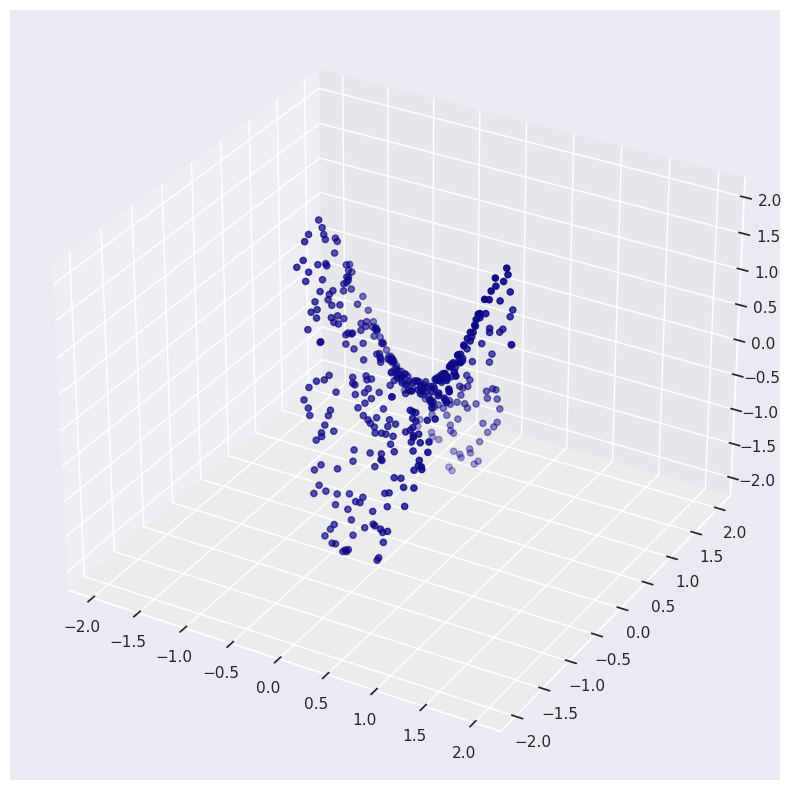

In [115]:
plot_3d(X)

## Baselines

In [6]:
from diffusion_curvature.radial_flattening_ae import radially_flatten_with_ae
from diffusion_curvature.mioflow_quicktrain import MIOFlowStandard

In [7]:
# Comparisons
from sklearn.decomposition import PCA
def pca_projection(array):
    # Create PCA instance with 2 components
    pca = PCA(n_components=2)
    # Perform PCA on the array
    projected_array = pca.fit_transform(array)
    return projected_array

In [8]:
def uniform_sampling_of_plane(array):
    return np.random.rand(*array.shape)

In [22]:
def mioflattener(array):
    MF = MIOFlowStandard(embedding_dimension=2)
    flattened_array = MF.fit_transform(array)
    return flattened_array

## Run Flattening
We'll define this via a function that takes the dataframe as input and returns it with a new column, containing a flattened version of each neighborhood.

In [10]:
def semifinal_flattener(NBD, flattening_func, recompute=False):
    if flattening_func.__name__ in NBD.columns and not recompute:
        print(f'Already computed {flattening_func.__name__}')
        return NBD
    flattened_spaces = []
    for X in tqdm(NBD['X']):
        flattened_spaces.append(
            flattening_func(X)
        )
    NBD[flattening_func.__name__] = flattened_spaces
    # save updated neighborhoods
    Neighborhoods.to_pickle('~/data/diffusion_curvature/Sampling_Semifinals_Neighborhoods.pkl')
    return NBD

In [27]:
def compute_distances(NBD):
    for flatname in tqdm(NBD.columns[3:]):
        # check if flatname has _dist in it
        if '_dist' not in flatname:
            Xs_flattened = NBD[flatname]
            sampling_dists = []
            for i in trange(len(Xs_flattened)):
                X_r = NBD['X'][i]
                X_f = Xs_flattened[i]
                D = NBD['D'][i]
                sampling_dists.append(
                    sampling_distance(X_r, X_f, D)
                )
            NBD[flatname + '_dist'] = sampling_dists
    return NBD

## Visualizations

In [39]:
def visualize_row_of_flattenings(df, i):
    row = df.iloc[i]

    bb = row['X']
    x = row['pca_projection']
    y = row['uniform_sampling_of_plane']
    z = row['radially_flatten_with_ae']
    zz = row['mioflattener']
    
    labels = {
        'pca_projection': row['pca_projection_dist'],
        'uniform_sampling_of_plane': row['uniform_sampling_of_plane_dist'],
        'radially_flatten_with_ae': row['radially_flatten_with_ae_dist'],
        'mioflattener': row['mioflattener_dist'],
        
    }
    
    fig, axs = plt.subplots(1, 4, figsize=(12, 4))
    
    axs[0].scatter(x[:, 0], x[:, 1], c=bb[:,0])
    axs[0].set_title('pca_projection_dist: {:.2f}'.format(labels['pca_projection']))
    axs[0].set_xlabel('Dimension 1')
    axs[0].set_ylabel('Dimension 2')
    
    axs[1].scatter(y[:, 0], y[:, 1],c=bb[:,0])
    axs[1].set_title('uniform_sampling_of_plane_dist: {:.2f}'.format(labels['uniform_sampling_of_plane']))
    axs[1].set_xlabel('Dimension 1')
    axs[1].set_ylabel('Dimension 2')
    
    axs[2].scatter(z[:, 0], z[:, 1],c=bb[:,0])
    axs[2].set_title('radially_flatten_with_ae_dist: {:.2f}'.format(labels['radially_flatten_with_ae']))
    axs[2].set_xlabel('Dimension 1')
    axs[2].set_ylabel('Dimension 2')

    axs[3].scatter(zz[:, 0], zz[:, 1],c=bb[:,0])
    axs[3].set_title('mioflattener: {:.2f}'.format(labels['mioflattener']))
    axs[3].set_xlabel('Dimension 1')
    axs[3].set_ylabel('Dimension 2')
    
    plt.tight_layout()
    plt.show()

# Results

First we'll compute flattened neighborhoods for each of our functions of interest, 
beginning with the two baselines:

In [13]:
Neighborhoods = semifinal_flattener(Neighborhoods, pca_projection)

  0%|          | 0/14 [00:00<?, ?it/s]

In [14]:
Neighborhoods = semifinal_flattener(Neighborhoods, uniform_sampling_of_plane)

  0%|          | 0/14 [00:00<?, ?it/s]

Then our more serious models:

In [15]:
Neighborhoods = semifinal_flattener(Neighborhoods, radially_flatten_with_ae)

  0%|          | 0/14 [00:00<?, ?it/s]

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Using s_gd2 for MDS. None


`Trainer.fit` stopped: `max_epochs=100` reached.
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Using s_gd2 for MDS. None


`Trainer.fit` stopped: `max_epochs=100` reached.
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Using s_gd2 for MDS. None


`Trainer.fit` stopped: `max_epochs=100` reached.
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Using s_gd2 for MDS. None


`Trainer.fit` stopped: `max_epochs=100` reached.
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Using s_gd2 for MDS. None


`Trainer.fit` stopped: `max_epochs=100` reached.
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Using s_gd2 for MDS. None


`Trainer.fit` stopped: `max_epochs=100` reached.
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Using s_gd2 for MDS. None


`Trainer.fit` stopped: `max_epochs=100` reached.
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Using s_gd2 for MDS. None


`Trainer.fit` stopped: `max_epochs=100` reached.
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Using s_gd2 for MDS. None


`Trainer.fit` stopped: `max_epochs=100` reached.
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Using s_gd2 for MDS. None


`Trainer.fit` stopped: `max_epochs=100` reached.
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Using s_gd2 for MDS. None


`Trainer.fit` stopped: `max_epochs=100` reached.
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Using s_gd2 for MDS. None


`Trainer.fit` stopped: `max_epochs=100` reached.
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Using s_gd2 for MDS. None


`Trainer.fit` stopped: `max_epochs=100` reached.
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Using s_gd2 for MDS. None


`Trainer.fit` stopped: `max_epochs=100` reached.


In [24]:
Neighborhoods = semifinal_flattener(Neighborhoods, mioflattener, recompute=True)

  0%|          | 0/14 [00:00<?, ?it/s]

Using s_gd2 for MDS. None


  0%|          | 0/10000 [00:00<?, ?it/s]

ToyModel(
  (func): ToyODE(
    (seq): Sequential(
      (0): Linear(in_features=5, out_features=16, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=16, out_features=32, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=32, out_features=16, bias=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Linear(in_features=16, out_features=2, bias=True)
    )
  )
)


Pretraining Epoch: 0it [00:00, ?it/s]

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Posttraining Epoch: 0it [00:00, ?it/s]

Using s_gd2 for MDS. None
Using s_gd2 for MDS. None


  0%|          | 0/10000 [00:00<?, ?it/s]

ToyModel(
  (func): ToyODE(
    (seq): Sequential(
      (0): Linear(in_features=5, out_features=16, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=16, out_features=32, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=32, out_features=16, bias=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Linear(in_features=16, out_features=2, bias=True)
    )
  )
)


Pretraining Epoch: 0it [00:00, ?it/s]

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Posttraining Epoch: 0it [00:00, ?it/s]

Using s_gd2 for MDS. None
Using s_gd2 for MDS. None


  0%|          | 0/10000 [00:00<?, ?it/s]

ToyModel(
  (func): ToyODE(
    (seq): Sequential(
      (0): Linear(in_features=5, out_features=16, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=16, out_features=32, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=32, out_features=16, bias=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Linear(in_features=16, out_features=2, bias=True)
    )
  )
)


Pretraining Epoch: 0it [00:00, ?it/s]

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Posttraining Epoch: 0it [00:00, ?it/s]

Using s_gd2 for MDS. None
Using s_gd2 for MDS. None


  0%|          | 0/10000 [00:00<?, ?it/s]

ToyModel(
  (func): ToyODE(
    (seq): Sequential(
      (0): Linear(in_features=5, out_features=16, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=16, out_features=32, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=32, out_features=16, bias=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Linear(in_features=16, out_features=2, bias=True)
    )
  )
)


Pretraining Epoch: 0it [00:00, ?it/s]

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Posttraining Epoch: 0it [00:00, ?it/s]

Using s_gd2 for MDS. None
Using s_gd2 for MDS. None


  0%|          | 0/10000 [00:00<?, ?it/s]

ToyModel(
  (func): ToyODE(
    (seq): Sequential(
      (0): Linear(in_features=5, out_features=16, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=16, out_features=32, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=32, out_features=16, bias=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Linear(in_features=16, out_features=2, bias=True)
    )
  )
)


Pretraining Epoch: 0it [00:00, ?it/s]

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Posttraining Epoch: 0it [00:00, ?it/s]

Using s_gd2 for MDS. None
Using s_gd2 for MDS. None


  0%|          | 0/10000 [00:00<?, ?it/s]

ToyModel(
  (func): ToyODE(
    (seq): Sequential(
      (0): Linear(in_features=5, out_features=16, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=16, out_features=32, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=32, out_features=16, bias=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Linear(in_features=16, out_features=2, bias=True)
    )
  )
)


Pretraining Epoch: 0it [00:00, ?it/s]

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Posttraining Epoch: 0it [00:00, ?it/s]

Using s_gd2 for MDS. None
Using s_gd2 for MDS. None


  0%|          | 0/10000 [00:00<?, ?it/s]

ToyModel(
  (func): ToyODE(
    (seq): Sequential(
      (0): Linear(in_features=5, out_features=16, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=16, out_features=32, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=32, out_features=16, bias=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Linear(in_features=16, out_features=2, bias=True)
    )
  )
)


Pretraining Epoch: 0it [00:00, ?it/s]

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Posttraining Epoch: 0it [00:00, ?it/s]

Using s_gd2 for MDS. None
Using s_gd2 for MDS. None


  0%|          | 0/10000 [00:00<?, ?it/s]

ToyModel(
  (func): ToyODE(
    (seq): Sequential(
      (0): Linear(in_features=5, out_features=16, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=16, out_features=32, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=32, out_features=16, bias=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Linear(in_features=16, out_features=2, bias=True)
    )
  )
)


Pretraining Epoch: 0it [00:00, ?it/s]

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Posttraining Epoch: 0it [00:00, ?it/s]

Using s_gd2 for MDS. None
Using s_gd2 for MDS. None


  0%|          | 0/10000 [00:00<?, ?it/s]

ToyModel(
  (func): ToyODE(
    (seq): Sequential(
      (0): Linear(in_features=5, out_features=16, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=16, out_features=32, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=32, out_features=16, bias=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Linear(in_features=16, out_features=2, bias=True)
    )
  )
)


Pretraining Epoch: 0it [00:00, ?it/s]

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Posttraining Epoch: 0it [00:00, ?it/s]

Using s_gd2 for MDS. None
Using s_gd2 for MDS. None


  0%|          | 0/10000 [00:00<?, ?it/s]

ToyModel(
  (func): ToyODE(
    (seq): Sequential(
      (0): Linear(in_features=5, out_features=16, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=16, out_features=32, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=32, out_features=16, bias=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Linear(in_features=16, out_features=2, bias=True)
    )
  )
)


Pretraining Epoch: 0it [00:00, ?it/s]

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Posttraining Epoch: 0it [00:00, ?it/s]

Using s_gd2 for MDS. None
Using s_gd2 for MDS. None


  0%|          | 0/10000 [00:00<?, ?it/s]

ToyModel(
  (func): ToyODE(
    (seq): Sequential(
      (0): Linear(in_features=5, out_features=16, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=16, out_features=32, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=32, out_features=16, bias=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Linear(in_features=16, out_features=2, bias=True)
    )
  )
)


Pretraining Epoch: 0it [00:00, ?it/s]

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Posttraining Epoch: 0it [00:00, ?it/s]

Using s_gd2 for MDS. None
Using s_gd2 for MDS. None


  0%|          | 0/10000 [00:00<?, ?it/s]

ToyModel(
  (func): ToyODE(
    (seq): Sequential(
      (0): Linear(in_features=5, out_features=16, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=16, out_features=32, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=32, out_features=16, bias=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Linear(in_features=16, out_features=2, bias=True)
    )
  )
)


Pretraining Epoch: 0it [00:00, ?it/s]

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Posttraining Epoch: 0it [00:00, ?it/s]

Using s_gd2 for MDS. None
Using s_gd2 for MDS. None


  0%|          | 0/10000 [00:00<?, ?it/s]

ToyModel(
  (func): ToyODE(
    (seq): Sequential(
      (0): Linear(in_features=5, out_features=16, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=16, out_features=32, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=32, out_features=16, bias=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Linear(in_features=16, out_features=2, bias=True)
    )
  )
)


Pretraining Epoch: 0it [00:00, ?it/s]

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Posttraining Epoch: 0it [00:00, ?it/s]

Using s_gd2 for MDS. None
Using s_gd2 for MDS. None


  0%|          | 0/10000 [00:00<?, ?it/s]

ToyModel(
  (func): ToyODE(
    (seq): Sequential(
      (0): Linear(in_features=5, out_features=16, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=16, out_features=32, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=32, out_features=16, bias=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Linear(in_features=16, out_features=2, bias=True)
    )
  )
)


Pretraining Epoch: 0it [00:00, ?it/s]

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Posttraining Epoch: 0it [00:00, ?it/s]

Using s_gd2 for MDS. None


In [25]:
Neighborhoods

,X,ks,D,pca_projection,uniform_sampling_of_plane,radially_flatten_with_ae,mioflattener,pca_projection_dist,uniform_sampling_of_plane_dist,radially_flatten_with_ae_dist
0,"[[0.0, 0.0, 1.0], [-0.5056789303677925, -0.539...",2.0,"[[10.50781626867326, 21.981239902156634, 28.63...","[[-0.011156002905793225, 0.034630126829086325]...","[[0.3039623909677194, 0.5207068347758379, 0.76...","[[-0.18358189, -0.46164554], [-0.14529538, -0....","[[0.6910092, 0.07106776], [0.70003235, 0.77092...",10.813301,11.034459,10.963005
1,"[[0.2669548688118699, 1.20444145167798, 1.5741...",0.5,"[[11.07571160620079, 19.706618351998486, 19.85...","[[-0.6931582398863203, -0.9205097344973917], [...","[[0.7341781801219284, 0.42382072457281694, 0.6...","[[0.6303861, 0.14227119], [0.42141068, 0.14819...","[[0.8084887, 0.6888929], [0.6574802, 0.8611818...",10.631023,11.001943,11.462499
2,"[[0.8302649684519964, 1.2886628935225246, 2.57...",0.222222,"[[9.715083881381329, 32.016558044043805, 15.46...","[[-0.5517396374919752, -1.3753183639828166], [...","[[0.22346958088631075, 0.7838828456792427, 0.2...","[[0.73120487, 1.4889369], [0.42717367, 0.90914...","[[0.7867155, 0.5614696], [0.69654506, 0.725902...",10.554104,10.946224,11.397366
3,"[[-1.8608777437387467, -1.3533552652615088, 3....",0.125,"[[10.591193164121615, 35.758100114457605, 16.2...","[[-1.9819581481977353, 1.0520601775789427], [0...","[[0.4763975315964889, 0.6368277542577094, 0.96...","[[0.7522354, -1.199306], [0.8287662, -1.935328...","[[0.030388981, 0.3684035], [0.15162376, 0.3373...",10.575911,10.898802,11.403512
4,"[[1.8094982902235515, -0.7178116503529858, 4.6...",0.08,"[[11.121389768516801, 35.07584151691036, 24.17...","[[-1.7992239746926189, 0.5626332086793128], [2...","[[0.9167652852215951, 0.6314499481721139, 0.06...","[[-1.6783168, -0.60840493], [-1.3116928, 0.103...","[[0.45060503, 0.43303832], [0.046138257, 0.194...",10.589941,10.939300,11.190608
5,"[[-1.5124845820878576, -2.4193025203622565, 5....",0.055556,"[[11.009050836645784, 28.86018229882384, 33.08...","[[0.08852024919990205, -2.85203208698642], [-1...","[[0.5967757111842948, 0.2609877177253076, 0.60...","[[5.2193046, -0.33465168], [5.524133, 0.000710...","[[0.7050971, 0.79074216], [0.797585, 0.3056193...",10.584619,11.024600,11.516617
6,"[[-1.4276941684519568, -1.9713438531657164, 6....",0.040816,"[[10.90734958000609, 18.252875454693495, 38.38...","[[-1.5173536913357266, -1.7933627199710367], [...","[[0.48747563183294595, 0.6326718141032631, 0.3...","[[2.1547, 0.8856245], [1.905891, 0.899055], [2...","[[2.4546733, -0.05193938], [1.1680815, -0.4738...",10.250708,10.656460,11.529409
7,"[[0.0, 0.0, 0.0], [-0.5948849444403481, 0.0896...","[-4.0, -0.6676264600113749, -0.109864902978721...","[[11.130911286186315, 19.949671260320663, 25.7...","[[-0.02421265362259282, 0.06468328633397269], ...","[[0.5999906632764276, 0.031938597784928024, 0....","[[-0.10223383, 0.24047463], [-0.3354421, 0.049...","[[0.32048133, 0.1413395], [0.4191199, 0.870497...",10.947486,11.192036,10.906455
8,"[[0.0, 0.0, 0.0], [-0.8921079259947202, -0.412...","[-0.25, -0.162172246530098, -0.197009809984279...","[[11.5803970825845, 27.657359354833, 23.023965...","[[-0.03208560884729366, 0.005637648144760282],...","[[0.502662937405282, 0.2602129957691812, 0.368...","[[0.39541143, -0.16305292], [0.60925084, -0.63...","[[0.4938504, 0.876561], [0.81299496, 0.4099028...",10.988948,11.352016,10.967103
9,"[[0.0, 0.0, 0.0], [-0.3435344781556513, -0.294...","[-0.04938271604938271, -0.04840011429553606, -...","[[10.07889358136316, 19.56256472725227, 22.463...","[[0.022982306235713283, -0.016501088603088722]...","[[0.9019543075947876, 0.2776800574490704, 0.31...","[[-0.1616647, -0.46340248], [-0.32914072, -0.6...","[[0.4861721, 0.88441104], [0.66775507, 0.87905...",10.913048,11.589297,11.033078


## Analysis

In [28]:
Neighborhoods = compute_distances(Neighborhoods)

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

In [33]:
Neighborhoods[["ks","pca_projection_dist","radially_flatten_with_ae_dist","uniform_sampling_of_plane_dist","mioflattener_dist"]]

,ks,pca_projection_dist,radially_flatten_with_ae_dist,uniform_sampling_of_plane_dist,mioflattener_dist
0,2.0,10.813301,10.963005,11.034459,11.025771
1,0.5,10.631023,11.462499,11.001943,10.922291
2,0.222222,10.554104,11.397366,10.946224,10.892994
3,0.125,10.575911,11.403512,10.898802,10.897348
4,0.08,10.589941,11.190608,10.939300,10.923599
5,0.055556,10.584619,11.516617,11.024600,11.004874
6,0.040816,10.250708,11.529409,10.656460,10.785368
7,"[-4.0, -0.6676264600113749, -0.109864902978721...",10.947486,10.906455,11.192036,11.233559
8,"[-0.25, -0.162172246530098, -0.197009809984279...",10.988948,10.967103,11.352016,11.322334
9,"[-0.04938271604938271, -0.04840011429553606, -...",10.913048,11.033078,11.589297,11.613418


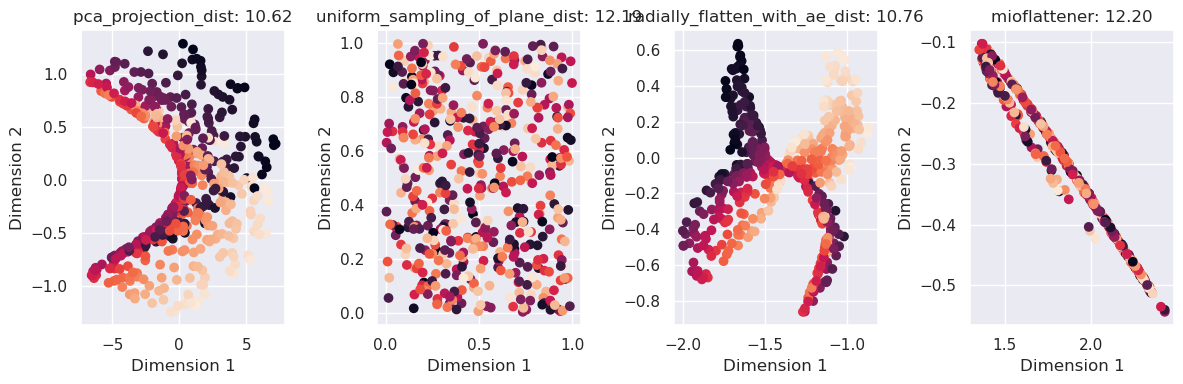

In [105]:
visualize_row_of_flattenings(Neighborhoods,13)

## Closer Analysis of MIOFlattener

In [92]:
testarray = Neighborhoods.iloc[1]['X']

In [93]:
MF = MIOFlowStandard(embedding_dimension=2, n_epochs_ode=400)

In [94]:
flattened_array = MF.fit_transform(testarray)

Using s_gd2 for MDS. None


  0%|          | 0/10000 [00:00<?, ?it/s]

ToyModel(
  (func): ToyODE(
    (seq): Sequential(
      (0): Linear(in_features=5, out_features=16, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=16, out_features=32, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=32, out_features=16, bias=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Linear(in_features=16, out_features=2, bias=True)
    )
  )
)


Pretraining Epoch: 0it [00:00, ?it/s]

Epoch:   0%|          | 0/400 [00:00<?, ?it/s]

Posttraining Epoch: 0it [00:00, ?it/s]

Using s_gd2 for MDS. None


In [95]:
flattened_array[1]

array([0.7221788, 0.6211829], dtype=float32)

In [96]:
show_doc(MIOFlowStandard.visualize_autoencoder)

---

### MIOFlowStandard.visualize_autoencoder

>      MIOFlowStandard.visualize_autoencoder (X=None, n_samples=1000)

Using s_gd2 for MDS. None


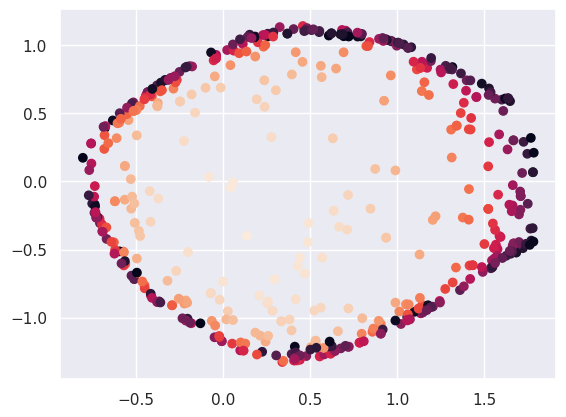

In [97]:
MF.visualize_autoencoder(X=testarray, n_samples = len(testarray))


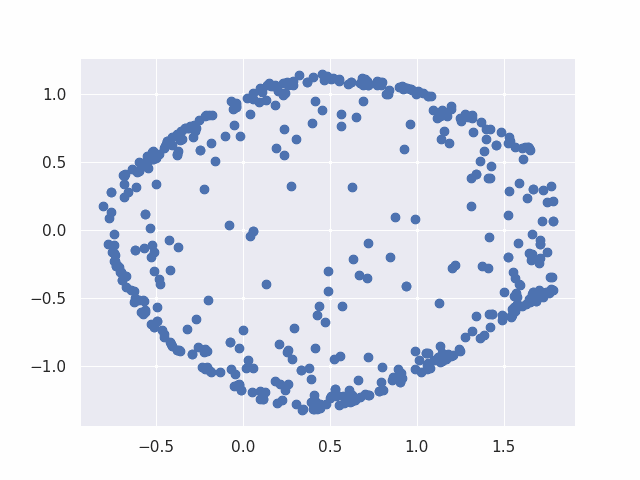

In [98]:
MF.training_gif()

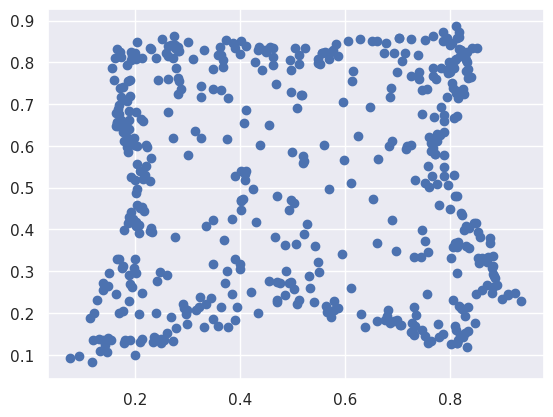

In [91]:
plt.scatter(flattened_array[:,0], flattened_array[:,1])

# Conclusion